In [1]:
from chromatic_fitting import *
import celerite2
from celerite2.theano import terms, GaussianProcess

Running chromatic_fitting v0.11.0!

This program is running on:
Python v3.9.7 (default, Sep 16 2021, 08:50:36) 
[Clang 10.0.0 ]
numpy v1.21.6
chromatic v0.4.5
pymc3 v3.11.4
pymc3_ext v0.1.1
exoplanet v0.5.3


In [19]:
def plot_prediction(self, gp, plot_var=True, legend=True):
    plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3, label="data")
    plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0, label="truth")

    if gp:
        mu, variance = eval_in_model(gp.predict(y, t=true_t, return_var=True),model=self._pymc3_model)
        plt.plot(true_t, mu, label="prediction", c='C0')
        if plot_var:
            sigma = np.sqrt(variance)
            plt.fill_between(true_t, mu - sigma, mu + sigma, color="C0", alpha=0.2)

    plt.xlabel("x [day]")
    plt.ylabel("y [ppm]")
    plt.xlim(0, 10)
    plt.ylim(-2.5, 2.5)
    if legend:
        plt.legend()

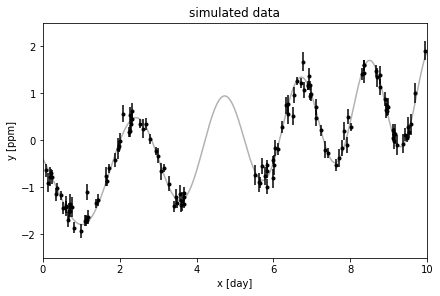

In [2]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

t = np.sort(
    np.append(
        np.random.uniform(0, 3.8, 57),
        np.random.uniform(5.5, 10, 68),
    )
)  # The input coordinates must be sorted
yerr = np.random.uniform(0.08, 0.22, len(t))
y = (
    0.2 * (t - 5)
    + np.sin(3 * t + 0.1 * (t - 5) ** 2)
    + yerr * np.random.randn(len(t))
)

true_t = np.linspace(0, 10, 500)
true_y = 0.2 * (true_t - 5) + np.sin(3 * true_t + 0.1 * (true_t - 5) ** 2)

plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.xlabel("x [day]")
plt.ylabel("y [ppm]")
plt.xlim(0, 10)
plt.ylim(-2.5, 2.5)
_ = plt.title("simulated data")

🌈🤖 The time scale for this rainbow is '?',
and there are 125 time centers and
125 time edges defined.

It's hard to imshow something with a time axis
that isn't linearly or logarithmically uniform, or doesn't
at least have its time edges defined. We're giving up
and just using the time index as the time axis.

If you want a real time axis, one solution would
be to bin your times to a more uniform grid with
`rainbow.bin(dt=...)` (for linear times).



<Axes: xlabel='Time Index', ylabel='log$_{10}$[Wavelength/($\\mathrm{\\mu m}$)]'>

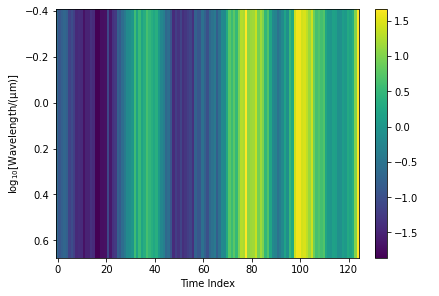

In [3]:
r = SimulatedRainbow(time=t*u.day, R=2)
r.flux *= y
r.uncertainty[:,:] = yerr
r.imshow()

In [4]:
r

<Simulated🌈(5w, 125t)>

In [25]:
# set up polynomial model:
p1 = GPModel(kernel='sho', name='periodic')

p1.setup_parameters(
    sigma = WavelikeFitted(Normal,mu=1, sigma=100),
    rho = Fitted(Normal,mu=1, sigma=100),
    tau = Fitted(Normal,mu=1, sigma=100),
)
p1.summarize_parameters()

# print a summary of all params:
# p1.summarize_parameters()

periodic_sigma =
  <🧮 WavelikeFitted Normal(mu=1, sigma=100, name='periodic_sigma') for each wavelength 🧮>

periodic_rho =
  <🧮 Fitted Normal(mu=1, sigma=100, name='periodic_rho') 🧮>

periodic_tau =
  <🧮 Fitted Normal(mu=1, sigma=100, name='periodic_tau') 🧮>



In [26]:
# set up polynomial model:
p2 = GPModel(kernel='sho', name='nonperiodic')

p2.setup_parameters(
    sigma = Fitted(Normal,mu=1, sigma=100),
    rho = Fitted(Normal,mu=1, sigma=100),
    Q = 0.25,
)

# print a summary of all params:
p2.summarize_parameters()

nonperiodic_sigma =
  <🧮 Fitted Normal(mu=1, sigma=100, name='nonperiodic_sigma') 🧮>

nonperiodic_rho =
  <🧮 Fitted Normal(mu=1, sigma=100, name='nonperiodic_rho') 🧮>

nonperiodic_Q =
  <🧮 Fixed | 0.25 🧮>



In [32]:
p = p1 + p2

/Users/catrionamurray/opt/anaconda3/lib/python3.9/site-packages/chromatic_fitting/models/lightcurve.py:166: UserWarning: periodic in the parameter name: periodic_sigma. Please avoid having the model name in the parameter name as it can get confusing!
  warnings.warn(
/Users/catrionamurray/opt/anaconda3/lib/python3.9/site-packages/chromatic_fitting/models/lightcurve.py:166: UserWarning: nonperiodic in the parameter name: nonperiodic_sigma. Please avoid having the model name in the parameter name as it can get confusing!
  warnings.warn(


In [33]:
p

<chromatic combined model 'combined' 🌈, models: <chromatic GP model 'periodic', with sho kernel 🌈> + <chromatic GP model 'nonperiodic', with sho kernel 🌈>

In [34]:
p.attach_data(r)

In [35]:
p.add_jitter(Fitted(Normal,name='log_jitter', mu=0, sigma=3))

In [36]:
p.log_jitter

<🧮 Fitted Normal(name='log_jitter', mu=0, sigma=3) 🧮>

In [37]:
p.setup_lightcurves()

/Users/catrionamurray/opt/anaconda3/lib/python3.9/site-packages/chromatic_fitting/models/gp.py:99: UserWarning: 
You have not provided a mean to the GP. Are you sure this is right?
If you want to add a mean please run {self}.add_mean. We will proceed assuming a mean of 0.

  warnings.warn(


{'sigma': Subtensor{int64}.0, 'rho': Subtensor{int64}.0, 'tau': Subtensor{int64}.0}
{'sigma': Subtensor{int64}.0, 'rho': Subtensor{int64}.0, 'tau': Subtensor{int64}.0}
{'sigma': Subtensor{int64}.0, 'rho': Subtensor{int64}.0, 'tau': Subtensor{int64}.0}
{'sigma': Subtensor{int64}.0, 'rho': Subtensor{int64}.0, 'tau': Subtensor{int64}.0}
{'sigma': Subtensor{int64}.0, 'rho': Subtensor{int64}.0, 'tau': Subtensor{int64}.0}
{'sigma': Subtensor{int64}.0, 'rho': Subtensor{int64}.0, 'Q': 0.25}


WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0


{'sigma': Subtensor{int64}.0, 'rho': Subtensor{int64}.0, 'Q': 0.25}


WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0


{'sigma': Subtensor{int64}.0, 'rho': Subtensor{int64}.0, 'Q': 0.25}


WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0


{'sigma': Subtensor{int64}.0, 'rho': Subtensor{int64}.0, 'Q': 0.25}


WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0


{'sigma': Subtensor{int64}.0, 'rho': Subtensor{int64}.0, 'Q': 0.25}


WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0


In [38]:
print(p._pymc3_model)

   periodic_sigma ~ Normal
     periodic_rho ~ Normal
     periodic_tau ~ Normal
       log_jitter ~ Normal
nonperiodic_sigma ~ Normal
  nonperiodic_rho ~ Normal


<ErrorbarContainer object of 3 artists>

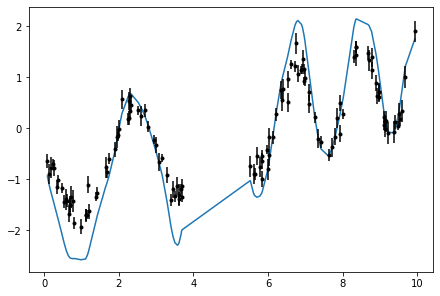

In [39]:
plt.plot(p.data.time, p.initial_guess['wavelength_0'][0])
plt.plot(p.data.time, p.data.flux[0,:],'k.')
plt.errorbar(p.data.time, p.data.flux[0,:], p.data.uncertainty[0,:], color='k', linestyle='None')

In [40]:
p.setup_likelihood()

/Users/catrionamurray/opt/anaconda3/lib/python3.9/site-packages/chromatic_fitting/models/combined.py:508: UserWarning: 
You have not provided a mean to the GP. Are you sure this is right?
If you want to add a mean please run {self}.add_mean. We will proceed assuming a mean of 0.

  warnings.warn(


In [41]:
p._pymc3_model.test_point

{'periodic_sigma': array([1., 1., 1., 1., 1.]),
 'periodic_rho': array([1.]),
 'periodic_tau': array([1.]),
 'log_jitter': array(0.),
 'nonperiodic_sigma': array([1.]),
 'nonperiodic_rho': array([1.])}

In [42]:
p._pymc3_model.check_test_point()

periodic_sigma       -27.62
periodic_rho          -5.52
periodic_tau          -5.52
log_jitter            -2.02
nonperiodic_sigma     -5.52
nonperiodic_rho       -5.52
gp_w0               -153.74
gp_w1               -153.74
gp_w2               -153.74
gp_w3               -153.74
gp_w4               -153.74
Name: Log-probability of test_point, dtype: float64

optimizing logp for variables: [nonperiodic_rho, nonperiodic_sigma, log_jitter, periodic_tau, periodic_rho, periodic_sigma]


message: Desired error not necessarily achieved due to precision loss.
logp: -820.422812331942 -> -22.791462380009634


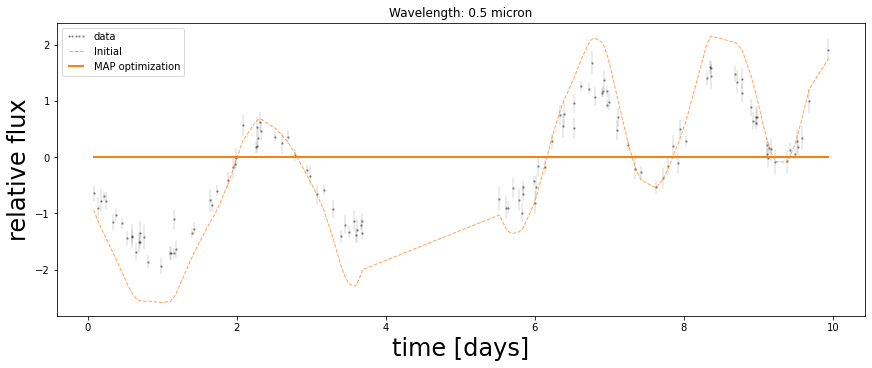

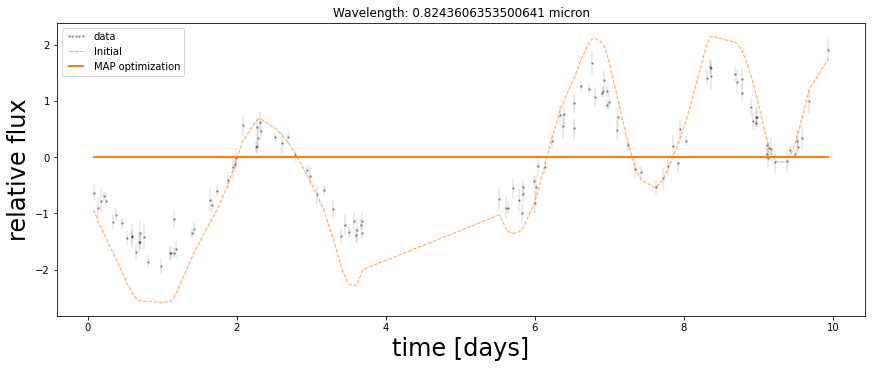

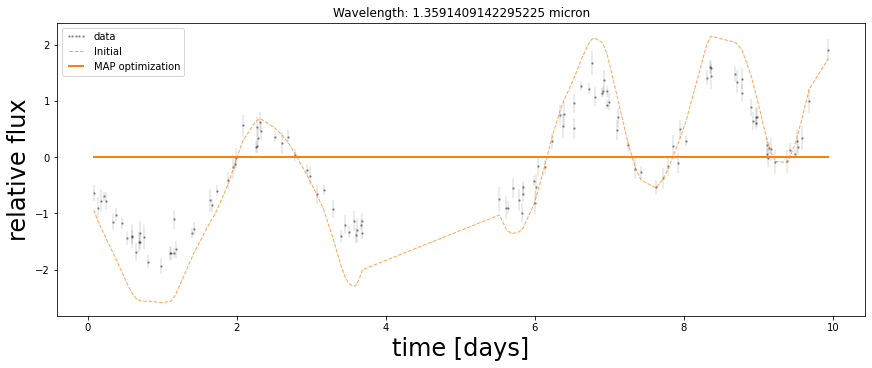

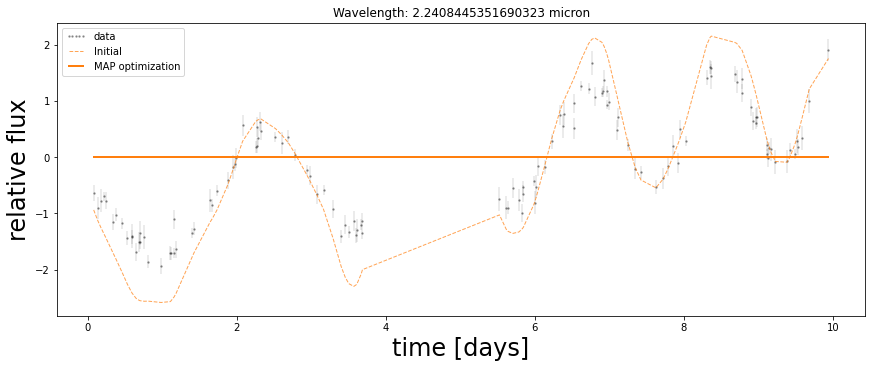

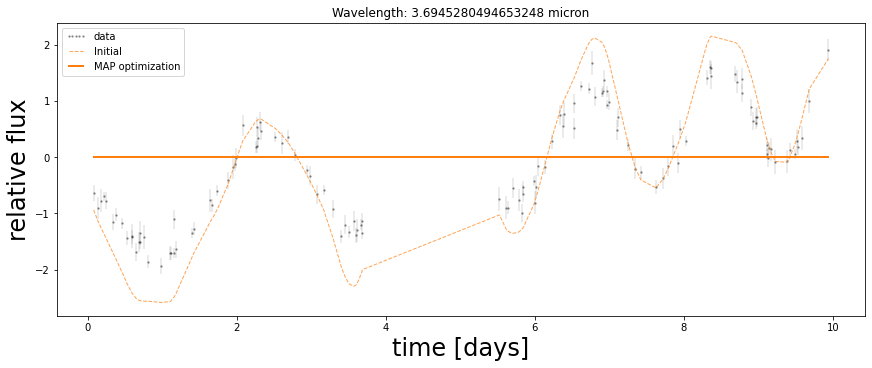

In [43]:
# optimize for initial values!
opt = p.optimize(plot=True)

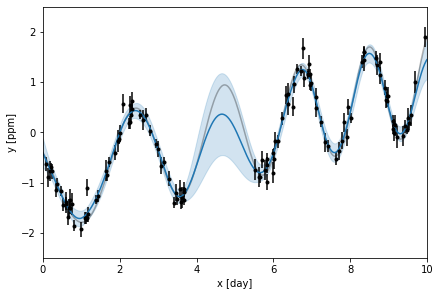

In [46]:
gp = p.generate_gp_model_from_params(params=opt)#new_results)
plot_prediction(p, gp, plot_var=True, legend=False)

In [48]:
# put those initial values into the sampling and define the number of tuning and draw steps, 
# as well as the number of chains.
p.sample(sampling_method=pmx.sample, start=opt, tune=2000, draws=4000, chains=4, cores=4, return_inferencedata=False)

Sampling model using the <function sample at 0x7fc3e6f63d30> method


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nonperiodic_rho, nonperiodic_sigma, log_jitter, periodic_tau, periodic_rho, periodic_sigma]


/Users/catrionamurray/opt/anaconda3/lib/python3.9/site-packages/pymc3/step_methods/hmc/integration.py:108: RuntimeWarning: invalid value encountered in double_scalars
  energy = kinetic - logp
Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 546 seconds.
There were 160 divergences after tuning. Increase `target_accept` or reparameterize.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 59 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


                           mean         sd    hdi_16%     hdi_84%  mcse_mean   
periodic_sigma[0]      1.171020   0.466989   0.672938    1.345440   0.012123  \
periodic_sigma[1]      1.172148   0.472975   0.652420    1.320719   0.012293   
periodic_sigma[2]      1.173217   0.472274   0.645648    1.310946   0.011843   
periodic_sigma[3]      1.176067   0.474601   0.654960    1.331455   0.012264   
periodic_sigma[4]      1.173460   0.474857   0.669536    1.341803   0.011917   
periodic_rho[0]        2.021990   0.041180   1.979234    2.061228   0.000462   
periodic_tau[0]       21.562762  19.881024   5.363977   22.058832   0.601852   
log_jitter            -7.286415   1.034924  -7.845181   -6.104056   0.015026   
nonperiodic_sigma[0]  -3.236668   1.648668  -3.796304   -1.230329   0.031113   
nonperiodic_rho[0]    83.639844  48.231240  23.853104  105.105167   0.887804   

                       mcse_sd     ess_bulk     ess_tail     r_hat  
periodic_sigma[0]     0.008811  2124.343963  1876.

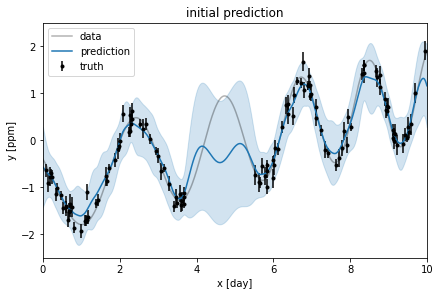

In [49]:
plt.title("initial prediction")
plot_prediction(p, p.gp[0])

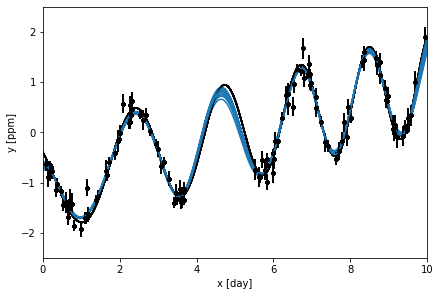

In [50]:
i=0
plt.figure()
for trace in p.trace[:50]:
    gp = p.generate_gp_model_from_params(trace, i=i)
    plot_prediction(p, gp, plot_var=False, legend=False)

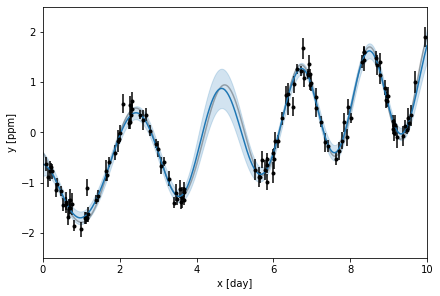

In [51]:
gp = p.generate_gp_model_from_params(p.summary['mean'])#new_results)
plot_prediction(p, gp, plot_var=True, legend=False)

In [ ]:
p.kernel_func

{'wavelength_0': array([<celerite2.theano.terms.TermSum object at 0x7fd514891610>,
       dtype=object)}

In [174]:
def kernel_func(self, params, i=0):

    for imod, mod in enumerate(self._chromatic_models.values()):
        new_params = return_only_keys_with_string_at_start_of_dictionary(params, f"{mod.name}_")
        new_params = remove_all_keys_with_string_from_dictionary(new_params, 'interval')
        new_params = remove_string_from_each_dictionary_key(new_params, f"{mod.name}_")
        new_params = remove_string_from_each_dictionary_key(new_params, f"[{i}]")
        new_params = extract_index_from_each_dictionary_key(new_params, index=i)
#         print(new_params)

        model_params_without_name = remove_string_from_each_dictionary_key(mod.parameters, f"{mod.name}_")

        specific_params = {}
#         print(new_params.keys(), model_params_without_name.keys())
        for p in model_params_without_name.keys():
            if p in new_params.keys():
                specific_params[p] = new_params[p]
            elif isinstance(model_params_without_name[p], WavelikeFixed):
                specific_params[p] = model_params_without_name[p].value[i]
            elif isinstance(model_params_without_name[p], Fixed):
                specific_params[p] = model_params_without_name[p].value

#         print(specific_params)
        k = mod.kernel_func(**specific_params)

        if imod==0:
            k_func = k
        else:
            k_func = combination_options_array[self.how_to_combine[imod-1]](k_func, k)
        
    return k_func

In [175]:
trace

{'periodic_sigma': array([-2.40492058,  9.1429832 ,  8.1138491 , -3.25069468, 15.85257971]),
 'periodic_rho': array([11.74016999]),
 'periodic_tau': array([0.00018747]),
 'log_jitter': -9.797907159569242,
 'nonperiodic_sigma': array([2.78436265]),
 'nonperiodic_rho': array([7.95954811])}

In [176]:
kernel_func(p, trace,i=0)

In [86]:
a = remove_all_keys_with_string_from_dictionary(p.summary['mean'], 'interval')
a = remove_string_from_each_dictionary_key(a, '[0]')
a = remove_string_from_each_dictionary_key(a, 'periodic_')
a

{'sigma': -0.1986874,
 'rho': -1.2201921,
 'tau': 8.8036694,
 'log_jitter': -8.0181288,
 'nonsigma': 3.0990975,
 'nonrho': 28.7619113}

In [81]:
remove_string_from_each_dictionary_key(trace, 'periodic_')

{'sigma': array([-0.06153793]),
 'rho': array([-3.93826454]),
 'tau': array([-110.71292005]),
 'log_jitter': -7.83000991453376,
 'nonsigma': array([2.73804184]),
 'nonrho': array([8.9164863])}

In [167]:
def remove_string_from_each_dictionary_key(dict_old, string_to_remove):
    dict_new = {}
    for k, v in dict_old.items():
        new_k = k.replace(string_to_remove,"")
        dict_new[new_k] = v
    return dict_new

def remove_keys_from_dictionary(dict_old, keys_to_remove):
    dict_new = dict_old.copy()
    [dict_new.pop(k) for k in keys_to_remove]
    return dict_new

def remove_all_keys_with_string_from_dictionary(dict_old, string_to_remove):
    dict_new = {}
    for k, v in dict_old.items():
        if string_to_remove not in k:
            dict_new[k] = v
    return dict_new

def return_only_keys_with_string_from_dictionary(dict_old, string_to_return):
    dict_new = {}
    for k, v in dict_old.items():
        if string_to_return in k:
            dict_new[k] = v
    return dict_new

def return_only_keys_with_string_at_start_of_dictionary(dict_old, start_string_to_return):
    dict_new = {}
    for k, v in dict_old.items():
        if k[:len(start_string_to_return)] == start_string_to_return:
            dict_new[k] = v
    return dict_new

def extract_index_from_each_dictionary_key(dict_old, index):
    dict_new = {}
    for k, v in dict_old.items():
        if type(v) == list or type(v)==np.ndarray:
            try:
                dict_new[k] = v[index]
            except Exception:
                dict_new[k] = v[0]
        else:
            dict_new[k] = v
    return dict_new

In [ ]:
new_params = remove_all_keys_with_string_from_dictionary(params, 'interval')
        new_params = remove_string_from_each_dictionary_key(new_params, f"{self.name}_")
        new_params = remove_string_from_each_dictionary_key(new_params, f"[{i}]")
        extra_params = {}
        for name, default_value in zip(["log_jitter", "mean"], [1.0, 0.0]):
            if name in new_params.keys():
                extra_params[name] = new_params[name]
                new_params.pop(name)
            else:
                extra_params[name] = default_value

        kernel = self.kernel_func(**new_params)

        x = self.data.get(self.independant_variable)
        if self.independant_variable == "time":
            x = x.to_value("day")

        gp = GaussianProcess(
            kernel,
            mean=extra_params["mean"],
            t=x,
            diag=self.data.uncertainty[i, :] + np.exp(extra_params["log_jitter"]),
        )

In [90]:
a = {'a':1, 'ba':2, 'c':3}

In [99]:
return_only_keys_with_string_at_start_of_dictionary(a,'b')

{'ba': 2}

In [95]:
'kdfdjdkfjslk'[:len('kd')]

'kd'

In [94]:
len('kd')

2